In [1]:
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np
from models import KMeansPartitioner
from sklearn import preprocessing
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models import hofts

from models import sthofts
import matplotlib.pyplot as plt

In [2]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

In [3]:
train_df = pd.read_pickle("train_df.pkl")
train_clean_df = pd.read_pickle("train_clean_df.pkl")
train_residual_df = pd.read_pickle("train_residual_df.pkl")

test_df = pd.read_pickle("test_df.pkl")
test_clean_df = pd.read_pickle("test_clean_df.pkl")
test_residual_df = pd.read_pickle("test_residual_df.pkl")

In [5]:
#Remover AP_3 por conta dos outliers 
train_df.drop(columns=['AP_3'], inplace=True)
train_clean_df.drop(columns=['AP_3'], inplace=True)
train_residual_df.drop(columns=['AP_3'], inplace=True)

test_df.drop(columns=['AP_3'], inplace=True)
test_clean_df.drop(columns=['AP_3'], inplace=True)
test_residual_df.drop(columns=['AP_3'], inplace=True)

ValueError: labels ['AP_3'] not contained in axis

1 - Normalizar treinamento e teste juntos
  - Recuperar valor apos prediçao - OK
    - Denormalizar - OK
    - Somar com clean - Substituir por SSA
  - Medir RMSE para estacao AP_1 - OK

- Otimizar metrica de distancia - OK?
- Estudar rotina de benchmark
- Estudar SSA

Testes distribuidos
2 - Definir ranges para ordem e numero de clusters - Para 100 clusterstrava as maquinas
3 - Estudar rotina de benchmark da pyFTS
    - Como salvar os resultados?
    - Como executar rotinas multivariadas?

4 - Comparar valores com HOFTS simples

In [6]:
df = train_df.append(test_df)
normalized_train_df = (train_df-df.min())/(df.max()-df.min())
normalized_test_df = (test_df-df.min())/(df.max()-df.min())

train = normalized_train_df.values
test = normalized_test_df.values

In [7]:
k = 50

fuzzy_sets = KMeansPartitioner.KMeansPartitioner(data=train, npart=k, batch_size=1000, init_size=k*3)


_order = 6

model_hofts = sthofts.SpatioTemporalHighOrderFTS("FTS", nlags=_order, partitioner=fuzzy_sets)


In [8]:
model_hofts.order

6

In [9]:
#model_hofts.fit(train, dump = 'time', num_batches=10)
model_hofts.fit(train, dump = 'time', num_batches=100, distributed=True, nodes=['192.168.1.3','192.168.1.8'])
#model_hofts.fit(train, dump = 'time', num_batches=100, distributed=True, nodes=['192.168.1.3'])


forecast_hofts = model_hofts.predict(test)

2018-05-11 13:38:50 pycos - version 4.6.5 with kqueue I/O notifier
2018-05-11 13:38:50 dispy - dispy client version: 4.8.7
2018-05-11 13:38:50 dispy - Storing fault recovery information in "_dispy_20180511133850"
2018-05-11 13:38:50 dispy - dispy client at 192.168.1.3:51347
2018-05-11 13:38:50 dispy - Started HTTP server at ('0.0.0.0', 8181)
[ 13:38:50] Distrituted Train Started
[ 13:38:51] Processing batch 1
2018-05-11 13:38:51 dispy - Discovered 192.168.1.3:51348 (minds-imac-1.local) with 3 cpus
2018-05-11 13:38:51 dispy - Running job 111977289672 on 192.168.1.3
2018-05-11 13:38:51 dispy - Running job 111977289552 on 192.168.1.3
2018-05-11 13:38:51 dispy - Running job 111977289792 on 192.168.1.3
2018-05-11 13:38:51 dispy - Running job 2 / 111977289672 on 192.168.1.3 (busy: 3 / 3)
2018-05-11 13:38:51 dispy - Running job 1 / 111977289552 on 192.168.1.3 (busy: 3 / 3)
2018-05-11 13:38:51 dispy - Running job 3 / 111977289792 on 192.168.1.3 (busy: 3 / 3)
2018-05-11 13:38:51 dispy - Discove

KeyboardInterrupt: 

2018-05-11 13:51:01 dispy - Invalid message from 192.168.1.3:57680 ignored


In [11]:
norm_frcst_df = pd.DataFrame(data=forecast_hofts, columns=df.columns)
denormalized_frcst_df = (norm_frcst_df * (df.max()-df.min())) + df.min()

56

In [12]:
y_obs = test_df['AP_1'].values
y_est = denormalized_frcst_df['AP_1'].values

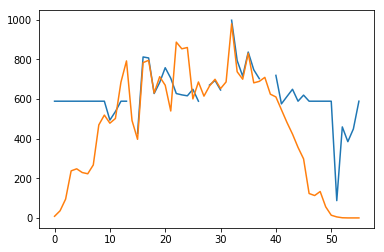

In [13]:
plt.plot(y_est)
plt.plot(y_obs[(_order - 1):])

In [14]:

_nrmse = normalized_rmse(y_obs[(_order - 1):], y_est)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  61.680780517 

2018-05-10 19:17:55 dispy - Discovered 192.168.1.8:51348 (MasterSystem.local) with 3 cpus
